# preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [2]:
admission_cvd_used = pd.read_csv('./admission_cvd.csv', index_col=0)  
admission_cvd_used = pd.get_dummies(admission_cvd_used, columns=['ADMISSION_TYPE'],drop_first=True)
%store -r admission_cvd_cal

In [3]:
count_lst = [int(sum(admission_cvd_cal[str(i)])) for i in range(20)]
print(count_lst)

[64, -77, -20, -112, -19, -86, -20, 110, -29, 56, 101, 44, 22, -9, -9, 20, 17, 62, 35, -8]


In [4]:
count_lst[5] = count_lst[5]/ 20
count_lst[10] = count_lst[10]/ 10
count_lst[17] = count_lst[17]/ 5

In [5]:
print(count_lst)

[64, -77, -20, -112, -19, -4.3, -20, 110, -29, 56, 10.1, 44, 22, -9, -9, 20, 17, 12.4, 35, -8]


In [6]:
lst = []
for i in admission_cvd_cal.index: 
    lst.append(sum([admission_cvd_cal[str(j)][i] for j in range(20)])) 

In [7]:
index = admission_cvd_cal['SUBJECT_ID'].value_counts().values >1 
m = admission_cvd_cal['SUBJECT_ID'].value_counts()
more_than_one = m.index[index] 

In [8]:
admission_cvd_cal = admission_cvd_cal.replace(False, 0)
admission_cvd_cal

,SUBJECT_ID,ADMI_DAYS,SPEND_TIME,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,0,1,2,3,4,...,10,11,12,13,14,15,16,17,18,19
1,23,19,1,0,0,0.021809,-0.020985,-0.000341,-0.021681,-0.007471,...,0.021474,0.022293,0.013128,0.011749,-0.009571,0.012738,-0.000369,0.014588,0.002119,-0.001119
7,28,28,1,0,0,0.021809,-0.020985,-0.000341,-0.021681,-0.007471,...,0.021474,0.022293,0.013128,0.011749,-0.009571,0.012738,-0.000369,0.014588,0.002119,-0.001119
14,35,7,5,0,0,0.021809,-0.020985,-0.000341,-0.021681,-0.007471,...,0.021474,0.022293,0.013128,0.011749,-0.009571,0.012738,-0.000369,0.014588,0.002119,-0.001119
15,36,11,3,1,0,0.021809,-0.020985,-0.000341,-0.021681,-0.007471,...,0.021474,0.022293,0.013128,0.011749,-0.009571,0.012738,-0.000369,0.014588,0.002119,-0.001119
18,37,30,1,1,0,-0.004344,-0.004047,0.001634,-0.012101,0.008386,...,0.009148,-0.007556,-0.016767,-0.023037,0.001442,-0.013623,0.017295,0.015959,0.005910,0.005914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58913,98634,13,1,1,0,0.021809,-0.020985,-0.000341,-0.021681,-0.007471,...,0.021474,0.022293,0.013128,0.011749,-0.009571,0.012738,-0.000369,0.014588,0.002119,-0.001119
58915,98639,6,4,0,0,-0.004344,-0.004047,0.001634,-0.012101,0.008386,...,0.009148,-0.007556,-0.016767,-0.023037,0.001442,-0.013623,0.017295,0.015959,0.005910,0.005914
58940,98714,1,-2,1,0,0.021809,-0.020985,-0.000341,-0.021681,-0.007471,...,0.021474,0.022293,0.013128,0.011749,-0.009571,0.012738,-0.000369,0.014588,0.002119,-0.001119
58944,98733,0,3,1,0,0.021809,-0.020985,-0.000341,-0.021681,-0.007471,...,0.021474,0.022293,0.013128,0.011749,-0.009571,0.012738,-0.000369,0.014588,0.002119,-0.001119


In [9]:
def vec_reshape(id):
    df_test = admission_cvd_cal[admission_cvd_cal['SUBJECT_ID']==id]
    df_test = df_test.set_index('SUBJECT_ID')
    x = df_test.values.reshape(1, -1)
    return x

In [10]:
subject_list = np.unique(admission_cvd_used['SUBJECT_ID'])
multi_coordinate = []
for id in subject_list:
    multi_coordinate.append(vec_reshape(id))

In [12]:
label = admission_cvd_cal[['SUBJECT_ID','0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19']]
label = label.replace(False, 0)

In [13]:
def label_reshape(id):
    df_test = label[admission_cvd_cal['SUBJECT_ID']==id]
    df_test = df_test.set_index('SUBJECT_ID')
    x = df_test.values.reshape(1, -1) 
    return x

In [14]:
y = []
for id in subject_list:
    if id in more_than_one:
        num = len(label[admission_cvd_cal['SUBJECT_ID']==id])
        temp = []
        for i in range(num):
            lst = list(label[admission_cvd_cal['SUBJECT_ID']==id].iloc[0,1:].values)
            temp = (temp or lst)   
        res = np.array(temp)
        res = res.reshape(1,-1)
        y.append(res)
    else:
        y.append(label_reshape(id))

In [15]:
train_x  = []
for i in range(len(multi_coordinate)):
    train_x.append(torch.DoubleTensor(multi_coordinate[i][0]))

In [16]:
train_y = []
for i in range(len(y)):
    train_y.append(torch.DoubleTensor((y[i][0])))    

#  model training 

In [17]:
x = rnn_utils.pad_sequence(train_x, batch_first=True)
y = rnn_utils.pad_sequence(train_y, batch_first=True)
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

# scale the data
x = sc.fit_transform(x)

In [18]:
x = np.reshape(x, (x.shape[0],1,x.shape[1]))
y = np.reshape(y, (y.shape[0],y.shape[1]))
x = torch.from_numpy(x)

In [19]:
print(x.shape)
print(y.shape)

torch.Size([6379, 1, 264])
torch.Size([6379, 20])


In [21]:
X_train, X_test = x[:int(x.shape[0]*0.80)],x[int(x.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]

In [22]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1,self.num_directions, hidden_size)
        outs = F.softmax(self.out(r_out[:, -1, :]))
        
        return outs, hidden_state

In [28]:
INPUT_SIZE = 264
HIDDEN_SIZE = 200
NUM_LAYERS = 3
OUTPUT_SIZE = 20
BATCH_SIZE = 32
# Hyper parameters

learning_rate = 0.001
num_epochs = 30

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
# rnn.cuda()

criterion = nn.BCELoss()
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


hidden_state = None

In [24]:
rnn  

RNN(
  (rnn): LSTM(264, 200, num_layers=3, dropout=0.1)
  (out): Linear(in_features=200, out_features=20, bias=True)
)

In [26]:
rnn = rnn.float()

In [29]:
history = []    
# we use all the data in one batch

for epoch in range(num_epochs):
    rnn.train()
    output, hidden_state = rnn(X_train.float(), hidden_state) 
    # print(output.size())

    loss = criterion(output, y_train.float())  
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    if epoch % 10 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test.float(), hidden_state)
        test_loss = criterion(test_output, y_test.float())
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

/Users/zhengdianchen/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0, loss 0.05466969311237335, eval loss 0.05341821908950806
epoch 1, loss 0.05429721996188164
epoch 2, loss 0.053773343563079834
epoch 3, loss 0.05282290652394295
epoch 4, loss 0.051261138170957565
epoch 5, loss 0.04932181164622307
epoch 6, loss 0.047435030341148376
epoch 7, loss 0.04573292285203934
epoch 8, loss 0.04401310160756111
epoch 9, loss 0.04229563847184181
epoch 10, loss 0.040681108832359314, eval loss 0.03939944505691528
epoch 11, loss 0.03914259746670723
epoch 12, loss 0.037642087787389755
epoch 13, loss 0.03617626428604126
epoch 14, loss 0.03473914787173271
epoch 15, loss 0.033338528126478195
epoch 16, loss 0.0319579616189003
epoch 17, loss 0.030594414100050926
epoch 18, loss 0.029241176322102547
epoch 19, loss 0.027888409793376923
epoch 20, loss 0.02653864398598671, eval loss 0.02642759121954441
epoch 21, loss 0.025185370817780495
epoch 22, loss 0.023829326033592224
epoch 23, loss 0.02247210219502449
epoch 24, loss 0.021115712821483612
epoch 25, loss 0.01976196281611

In [30]:
output.size()

torch.Size([5103, 20])

In [31]:
training_output = output.detach().numpy() 
testing_output = test_output.detach().numpy() 

In [32]:
prob_output = np.vstack([training_output, testing_output])

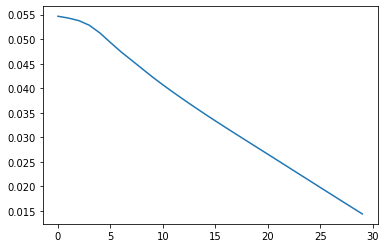

In [33]:
plt.plot(history)

In [35]:
id_list = np.unique(admission_cvd_used['HADM_ID'].values)[:6379]
dict_output = dict()
for i in range(6379):
    dict_output[id_list[i]] = prob_output[i]

In [37]:
cvd_list = ['Abnormal heart rhythms', 'arrhythmias', 'Aorta', 'Marfan syndrome','Congenital heart disease','Coronary artery','arteries', 'Deep vein thrombosis','pulmonary embolism','Heart attack','Heart failure', 'Heart muscle', 'cardiomyopathy', 'Heart valve','Pericardial', 'Peripheral vascular','Rheumatic heart','Stroke', 'vasulcar', 'blood vessel']
dict_disease = dict()
for i in range(20):
    dict_disease[i] = cvd_list[i]

In [38]:
dict_disease

{0: 'Abnormal heart rhythms',
 1: 'arrhythmias',
 2: 'Aorta',
 3: 'Marfan syndrome',
 4: 'Congenital heart disease',
 5: 'Coronary artery',
 6: 'arteries',
 7: 'Deep vein thrombosis',
 8: 'pulmonary embolism',
 9: 'Heart attack',
 10: 'Heart failure',
 11: 'Heart muscle',
 12: 'cardiomyopathy',
 13: 'Heart valve',
 14: 'Pericardial',
 15: 'Peripheral vascular',
 16: 'Rheumatic heart',
 17: 'Stroke',
 18: 'vasulcar',
 19: 'blood vessel'}

In [39]:
res_dic = dict()
for key in dict_output:
    res_dic[key]= [(dict_disease[idx],dict_output[key][idx]) for idx in dict_output[key].argsort()[-5:][::-1]]  

In [40]:
res_dic[100009]

[('Heart failure', 0.14209905),
 ('Deep vein thrombosis', 0.1363455),
 ('Heart muscle', 0.12376241),
 ('Heart attack', 0.11794421),
 ('Abnormal heart rhythms', 0.10576792)]

In [41]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'risk probability')

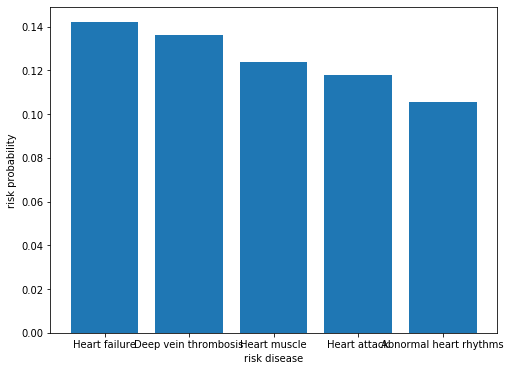

In [42]:
m = [0,1,2,3,4]
x = [res_dic[100009][idx][0] for idx in m]   
y = [res_dic[100009][idx][1] for idx in m] 
plt.figure(figsize=(8,6))
plt.bar(x,y)
plt.xlabel('risk disease')
plt.ylabel('risk probability')


In [43]:
df_code = pd.read_csv('D_ICD_DIAGNOSES.csv')

In [44]:
df_code = df_code.set_index('ICD9_CODE')

In [45]:
%store df_code 

Stored 'df_code' (DataFrame)


In [46]:
df_code.loc['01166',['SHORT_TITLE','LONG_TITLE']]

SHORT_TITLE                                TB pneumonia-oth test
LONG_TITLE     Tuberculous pneumonia [any form], tubercle bac...
Name: 01166, dtype: object

In [47]:
res_dic 

{100009: [('Heart failure', 0.14209905),
  ('Deep vein thrombosis', 0.1363455),
  ('Heart muscle', 0.12376241),
  ('Heart attack', 0.11794421),
  ('Abnormal heart rhythms', 0.10576792)],
 100012: [('Heart failure', 0.14211592),
  ('Deep vein thrombosis', 0.13649707),
  ('Heart muscle', 0.12366589),
  ('Heart attack', 0.11797891),
  ('Abnormal heart rhythms', 0.10581821)],
 100024: [('Heart failure', 0.1420824),
  ('Deep vein thrombosis', 0.13646916),
  ('Heart muscle', 0.1237636),
  ('Heart attack', 0.11789485),
  ('Abnormal heart rhythms', 0.10573202)],
 100034: [('Heart failure', 0.14207268),
  ('Deep vein thrombosis', 0.13652986),
  ('Heart muscle', 0.123869665),
  ('Heart attack', 0.1178625),
  ('Abnormal heart rhythms', 0.10566396)],
 100041: [('Heart failure', 0.1420795),
  ('Deep vein thrombosis', 0.1366209),
  ('Heart muscle', 0.12367866),
  ('Heart attack', 0.117980905),
  ('Abnormal heart rhythms', 0.10576642)],
 100050: [('Heart failure', 0.1419992),
  ('Deep vein thrombosis

In [48]:
dict_output 

{100009: array([1.0576792e-01, 4.0610107e-08, 1.1314831e-06, 1.1863525e-07,
        8.6954856e-07, 2.7748979e-07, 1.9558807e-07, 1.3634551e-01,
        4.6231787e-07, 1.1794421e-01, 1.4209905e-01, 1.2376241e-01,
        7.5695008e-02, 7.1999553e-04, 4.1385431e-07, 8.9296892e-02,
        1.9808415e-02, 9.5765039e-02, 9.2791893e-02, 2.3200514e-07],
       dtype=float32),
 100012: array([1.0581821e-01, 4.0674387e-08, 1.1328063e-06, 1.1874080e-07,
        8.7017611e-07, 2.7768607e-07, 1.9576825e-07, 1.3649707e-01,
        4.6355646e-07, 1.1797891e-01, 1.4211592e-01, 1.2366589e-01,
        7.5625040e-02, 7.2045258e-04, 4.1432202e-07, 8.9260325e-02,
        1.9819507e-02, 9.5564283e-02, 9.2930570e-02, 2.3231122e-07],
       dtype=float32),
 100024: array([1.0573202e-01, 4.0684846e-08, 1.1333019e-06, 1.1868766e-07,
        8.6974347e-07, 2.7777526e-07, 1.9590806e-07, 1.3646916e-01,
        4.6313824e-07, 1.1789485e-01, 1.4208239e-01, 1.2376360e-01,
        7.5647920e-02, 7.1964756e-04, 4.1426

In [49]:
%store id_list
%store dict_output
%store res_dic 

Stored 'id_list' (ndarray)
Stored 'dict_output' (dict)
Stored 'res_dic' (dict)
